In [1]:
import os, sys
import pickle
import json
from tqdm import tqdm
from collections import defaultdict, Counter, OrderedDict
import re
import string
import numpy as np
import random
import hashlib

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader

from transformers import BertModel, BertPreTrainedModel
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

In [2]:
KORQUAD_PATH = '/home/ubuntu/workspace/kaist.ir/qa/data/korquad'
BOOKQA_PATH = '/home/ubuntu/workspace/kaist.ir/qa/data/bookqa'
NEWSQA_PATH = '/home/ubuntu/workspace/kaist.ir/qa/data/newsqa'

KORQUAD_TRAIN = 'KorQuAD_v1.0_train.json'
KORQUAD_TEST = 'KorQuAD_v1.0_dev.json'
BOOKQA_TRAIN = 'bookqa_train.json'
BOOKQA_TEST = 'bookqa_valid.json'
NEWS_ALL = 'ko_nia_normal_squad_all.json'
NEWS_TRAIN = 'news_train_all_10.json'
NEWS_TEST = 'news_test_all_10.json'

In [3]:
class InputFeature():
    """A single set of features of data"""

    def __init__(self,
                 id,
                 input_ids,
                 token_type_ids,
                 attention_mask,
                 start_positions,
                 end_positions,
                 offset_mapping,
                 source=None
                 ):
        self.id = id
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_positions = start_positions
        self.end_positions = end_positions
        self.offset_mapping = offset_mapping
        self.source = source


def read_file(file_path, has_src=False):
    with open(file_path) as f:
        data = json.load(f)

    qa_data = defaultdict(list)
    for doc in data['data']:
        if has_src:
            source = doc['source']
        else:
            source = "all"
        for paragraph in doc['paragraphs']:
            context = paragraph['context'].replace('\u200b', '')
            for question_and_answers in paragraph['qas']:
                is_impossible = question_and_answers['is_impossible'] if 'is_impossible' in question_and_answers else None
                if not is_impossible:
                    question = question_and_answers['question']
                    answers = question_and_answers['answers']
                    # id = question_and_answers['id']
                    for answer in answers:
                        id = question + context
                        id = hashlib.shake_256(id.encode()).hexdigest(5)
                        qa_data['id'].append(id)
                        qa_data['context'].append(context)
                        qa_data['question'].append(question)
                        qa_data['answers'].append(answer)
                        if has_src:
                            qa_data['source'].append(source)
    return qa_data


def convert_to_features(qa_data, tokenizer, max_len, has_src=False):
    encodings = []
    for idx, (id, context, question, answers) in tqdm(enumerate(zip(qa_data['id'],
                                                                    qa_data['context'],
                                                                    qa_data['question'],
                                                                    qa_data['answers'])), total=len(qa_data['context'])):
        encoding = tokenizer(
            question,
            context,
            truncation=True,
            max_length=max_len,
            return_offsets_mapping=True,
            padding="max_length"
        )
        encoding['id'] = id
        if has_src:
            encoding['source'] = qa_data['source'][idx]
        else:
            encoding['source'] = None
        offset_mapping = encoding.pop("offset_mapping")
        encoding['offset_mapping'] = offset_mapping

        input_ids = encoding['input_ids']
        sequence_ids = encoding.sequence_ids(0)

        start_char = answers['answer_start']
        end_char = start_char + len(answers['text'])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if offset_mapping[token_start_index][0] <= start_char and offset_mapping[token_end_index][1] >= end_char:
            while token_start_index < len(offset_mapping) and offset_mapping[token_start_index][0] <= start_char:
                token_start_index += 1
            encoding["start_positions"] = token_start_index - 1
            while offset_mapping[token_end_index][1] >= end_char:
                token_end_index -= 1
            encoding["end_positions"] = token_end_index + 1
            # if encoding['start_positions'] < encoding['end_positions']:
            #     encodings.append(encoding)
            encodings.append(encoding)

    return [InputFeature(enc['id'],
                         enc['input_ids'],
                         enc['token_type_ids'],
                         enc['attention_mask'],
                         enc['start_positions'],
                         enc['end_positions'],
                         enc['offset_mapping'],
                         enc['source']) for enc in encodings]


In [122]:
squad_train_data = read_file(os.path.join(KORQUAD_PATH, KORQUAD_TRAIN))
squad_valid_data = read_file(os.path.join(KORQUAD_PATH, KORQUAD_TEST))
hub_train_data = read_file(os.path.join(NEWSQA_PATH, NEWS_TRAIN), has_src=True)
hub_valid_data = read_file(os.path.join(NEWSQA_PATH, NEWS_TEST), has_src=True)
book_train_data = read_file(os.path.join(BOOKQA_PATH, BOOKQA_TRAIN))
book_valid_data = read_file(os.path.join(BOOKQA_PATH, BOOKQA_TEST))

In [91]:
valid_squad_features = convert_to_features(squad_valid_data, tokenizer, max_len=512)
valid_hub_features = convert_to_features(hub_valid_data, tokenizer, max_len=512, has_src=True)

100%|██████████| 23169/23169 [00:45<00:00, 513.19it/s]


In [114]:
with open('../data/pkl/valid_squad_features.pkl', 'rb') as f:
    valid_squad_features_org = pickle.load(f)

with open('../data/pkl/ft_valid_hub_features.pkl', 'rb') as f:
    ft_valid_hub_features_org = pickle.load(f)

In [72]:
valid_sources = [f.source for f in ft_valid_hub_features_org]
print(Counter(valid_sources))

Counter({1: 908, 4: 722, 3: 690, 5: 618, 9: 611, 7: 608, 8: 578, 6: 538, 2: 444})


In [9]:
class CustomizedBertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, sigma=0.0):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]
        device = input_ids.device if input_ids is not None else inputs_embeds.device
        if position_ids is None:
            position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(input_shape)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        inputs_embeds = inputs_embeds + sigma * torch.randn_like(inputs_embeds, device=inputs_embeds.device)
        
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class CustomizedBertModel(BertModel):
    
    def __init__(self, config):
        super().__init__(config)
        self.config = config

        self.embeddings = CustomizedBertEmbeddings(config)
        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        sigma=0.01,
    ):

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids, position_ids=position_ids, token_type_ids=token_type_ids, inputs_embeds=inputs_embeds, sigma=sigma
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        outputs = (sequence_output, pooled_output,) + encoder_outputs[
            1:
        ]  # add hidden_states and attentions if they are here
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)


class CustomizedBertForQuestionAnswering(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = CustomizedBertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
    
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        l2_distance = ((total0-total1)**2).sum(2)
    
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.nansum(l2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

        kernel_val = [torch.exp(-l2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)
    
    def mmd(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX) + torch.mean(YY) - torch.mean(XY) - torch.mean(YX)
        return loss

    # @add_start_docstrings_to_callable(BERT_INPUTS_DOCSTRING.format("(batch_size, sequence_length)"))
    # @add_code_sample_docstrings(tokenizer_class=_TOKENIZER_FOR_DOC, checkpoint="bert-base-uncased")
    def forward(
        self,
        input_type=None,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        beta=0.01,
        sigma=0.01,
    ):

        if input_type is not None:
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                sigma=sigma,
            )

            sequence_output = outputs[0]

            logits = self.qa_outputs(sequence_output)
            start_logits, end_logits = logits.split(1, dim=-1)
            start_logits = start_logits.squeeze(-1)
            end_logits = end_logits.squeeze(-1)

            outputs = (start_logits, end_logits,) + outputs[2:]
            if start_positions is not None and end_positions is not None:
                # If we are on multi-GPU, split add a dimension
                if len(start_positions.size()) > 1:
                    start_positions = start_positions.squeeze(-1)
                if len(end_positions.size()) > 1:
                    end_positions = end_positions.squeeze(-1)
                # sometimes the start/end positions are outside our model inputs, we ignore these terms
                ignored_index = start_logits.size(1)
                start_positions.clamp_(0, ignored_index)
                end_positions.clamp_(0, ignored_index)

                loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
                start_loss = loss_fct(start_logits, start_positions)
                end_loss = loss_fct(end_logits, end_positions)

                # find answer, context and question position mask
                a_mask_1 = torch.zeros(token_type_ids.shape[0], token_type_ids.shape[1]+1).to(token_type_ids.device)
                a_mask_1[torch.arange(a_mask_1.shape[0]), start_positions] = 1
                a_mask_1 = a_mask_1.cumsum(dim=1)[:, :-1]
                a_mask_2 = torch.zeros(token_type_ids.shape[0], token_type_ids.shape[1]+1).to(token_type_ids.device)
                a_mask_2[torch.arange(a_mask_2.shape[0]), end_positions+1] = 1
                a_mask_2 = a_mask_2.cumsum(dim=1)[:, :-1]
                a_mask = a_mask_1 * (1 - a_mask_2)
                    
                splits = (input_ids == 102) * torch.arange(input_ids.shape[1], 0, -1).to(input_ids.device)
                _, splits = torch.sort(splits, -1, descending=True)
                splits = splits[:, :2]
                # splits = (input_ids == 102).nonzero()[:, 1].reshape(input_ids.size(0),-1)
                c_mask = (token_type_ids == 1) * attention_mask
                c_mask[torch.arange(c_mask.size(0)), splits[:, 0]] = 0
                c_mask[torch.arange(c_mask.size(0)), splits[:, 1]] = 0
                c_mask = c_mask * (1 - a_mask)

                q_mask = (token_type_ids == 0) * attention_mask
                q_mask[torch.arange(q_mask.size(0)), splits[:, 0]] = 0
                q_mask[:, 0] = 0
                
                a_rep = (sequence_output * a_mask.unsqueeze(-1)).sum(1) / a_mask.sum(-1).unsqueeze(-1)
                cq_mask = ((c_mask + q_mask) > 0) * 1.0
                cq_rep = (sequence_output * cq_mask.unsqueeze(-1)).sum(1) / cq_mask.sum(-1).unsqueeze(-1)

                can_loss = -self.mmd(cq_rep, a_rep)
                
                if len((input_type==0).nonzero()[:, 0]) != 0 and len((input_type==1).nonzero()[:, 0]) != 0:
                    a_rep_source = a_rep[(input_type==0).nonzero()[:, 0]].view(-1, a_rep.size(1))
                    a_rep_target = a_rep[(input_type==1).nonzero()[:, 0]].view(-1, a_rep.size(1))
                    cq_rep_source = cq_rep[(input_type==0).nonzero()[:, 0]].view(-1, cq_rep.size(1))
                    cq_rep_target = cq_rep[(input_type==1).nonzero()[:, 0]].view(-1, cq_rep.size(1))

                    can_loss += self.mmd(a_rep_source, a_rep_target) + self.mmd(cq_rep_source, cq_rep_target)
                
                total_loss = (start_loss + end_loss) / 2 + beta * can_loss
                if torch.isnan(total_loss).any():
                    print(start_loss, end_loss, beta, can_loss)
                outputs = (total_loss,) + outputs

            return outputs
        else:
            outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            sigma=0.0
        )

            sequence_output = outputs[0]

            logits = self.qa_outputs(sequence_output)
            start_logits, end_logits = logits.split(1, dim=-1)
            start_logits = start_logits.squeeze(-1).contiguous()
            end_logits = end_logits.squeeze(-1).contiguous()

            outputs = (start_logits, end_logits,) + outputs[2:]

            total_loss = None
            if start_positions is not None and end_positions is not None:
                # If we are on multi-GPU, split add a dimension
                if len(start_positions.size()) > 1:
                    start_positions = start_positions.squeeze(-1)
                if len(end_positions.size()) > 1:
                    end_positions = end_positions.squeeze(-1)
                # sometimes the start/end positions are outside our model inputs, we ignore these terms
                ignored_index = start_logits.size(1)
                start_positions = start_positions.clamp(0, ignored_index)
                end_positions = end_positions.clamp(0, ignored_index)

                loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
                start_loss = loss_fct(start_logits, start_positions)
                end_loss = loss_fct(end_logits, end_positions)
                total_loss = (start_loss + end_loss) / 2
        return ((total_loss,) + outputs) if total_loss is not None else outputs

In [47]:
# data_path = '/home/ubuntu/workspace/kaist.ir/qa/data'
# squad_valid_data = read_file(os.path.join(data_path, 'korquad/KorQuAD_v1.0_dev.json'))
# valid_squad_features = convert_to_features(squad_valid_data, tokenizer, max_len=512)

# valid_hub_data = read_file(os.path.join(data_path, 'newsqa/news_test_all_10.json'), has_src=True)
# valid_hub_features = convert_to_features(valid_hub_data, tokenizer, max_len=512, has_src=True)

100%|██████████| 23169/23169 [00:38<00:00, 598.85it/s]


In [7]:
with open('../data/pkl/valid_squad_features.pkl', 'rb') as f:
    valid_squad_features = pickle.load(f)

with open('../data/pkl/ft_valid_hub_features.pkl', 'rb') as f:
    ft_valid_hub_features = pickle.load(f)

with open('../data/pkl/ft_valid_book_features.pkl', 'rb') as f:
    ft_valid_book_features = pickle.load(f)

In [9]:
print(len(valid_squad_features))
print(len(ft_valid_hub_features))
print(len(ft_valid_book_features))

5717
5717
5889


# Source

In [6]:
source = 9
loss_type = 'ce'
with open(f'../data/pkl/valid_hub_features{source}.pkl', 'rb') as f:
    ft_valid_hub_features = pickle.load(f)

In [7]:
valid_features = ft_valid_hub_features
torch_input_ids = [torch.tensor(f.input_ids, dtype=torch.long) for f in valid_features]
all_input_ids = torch.cat([ii.unsqueeze(0) for ii in torch_input_ids], dim=0)
torch_token_type_ids = [torch.tensor(f.token_type_ids, dtype=torch.long) for f in valid_features]
all_token_type_ids = torch.cat([tti.unsqueeze(0) for tti in torch_token_type_ids], dim=0)
torch_attention_mask = [torch.tensor(f.attention_mask, dtype=torch.long) for f in valid_features]
all_attention_mask = torch.cat([am.unsqueeze(0) for am in torch_attention_mask], dim=0)
torch_start_positions = [torch.tensor(f.start_positions, dtype=torch.long) for f in valid_features]
all_start_positions = torch.cat([sp.unsqueeze(0) for sp in torch_start_positions], dim=0)
torch_end_positions = [torch.tensor(f.end_positions, dtype=torch.long) for f in valid_features]
all_end_positions = torch.cat([ep.unsqueeze(0) for ep in torch_end_positions], dim=0)
valid_dataset = TensorDataset(all_input_ids,
                                all_token_type_ids,
                                all_attention_mask,
                                all_start_positions,
                                all_end_positions)

In [8]:
valid_loader = DataLoader(valid_dataset,
                          batch_size=4,
                          shuffle=False,)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [10]:
model_path = f"/home/ubuntu/workspace/kaist.ir/qa/model/squad_news{source}.{loss_type}"
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
# model = CustomizedBertForQuestionAnswering.from_pretrained("klue/bert-base")
model = AutoModelForQuestionAnswering.from_pretrained('klue/bert-base')
model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.loss.bin")))

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model chec

<All keys matched successfully>

In [8]:
model = model.to(device)
model.eval()
pred_start_logits, pred_end_logits = [], []
# Run the model on some test examples
with torch.no_grad():
    val_losses = []
    valid_example_ct = 0
    for idx, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        valid_example_ct += batch[0].shape[0]
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        start_positions = batch[3].to(device)
        end_positions = batch[4].to(device)

        outputs = model(input_ids=input_ids,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)

        loss = outputs[0].item()
        pred_start_logits.append(outputs[1])
        pred_end_logits.append(outputs[2])
        val_losses.append(loss)
        if (idx + 1) % 200 == 0:
            print(f"valid loss is {loss}")
    avg_loss = sum(val_losses)/len(val_losses)
    print(f"average valid loss is {avg_loss}")

 24%|██▍       | 203/840 [00:08<00:27, 22.88it/s]

valid loss is 0.31977081298828125


 48%|████▊     | 404/840 [00:17<00:19, 22.87it/s]

valid loss is 0.9291682243347168


 72%|███████▏  | 602/840 [00:26<00:10, 22.82it/s]

valid loss is 0.3753718435764313


 96%|█████████▌| 803/840 [00:35<00:01, 22.87it/s]

valid loss is 0.7751610279083252


100%|██████████| 840/840 [00:36<00:00, 22.88it/s]

average valid loss is 0.9311441843664008


In [9]:
pred_start_logits = torch.cat([sl for sl in pred_start_logits], dim=0)
pred_end_logits = torch.cat([el for el in pred_end_logits], dim=0)     

In [10]:
def postprocess_qa_predictions(contexts, features, all_start_logits, all_end_logits, n_best_size=20, max_answer_length=30):
    predictions = OrderedDict()

    for idx, (context, f) in enumerate(zip(contexts, features)):
        # sep_idx = [idx for idx, ids in enumerate(f.input_ids) if ids == tokenizer.sep_token_id]
        # offset_context = tokenizer.decode(f.input_ids[sep_idx[0]+1:sep_idx[1]])
        valid_answers = []
        offset_mapping = f.offset_mapping
        start_logits = all_start_logits[idx].cpu().numpy()
        end_logits = all_end_logits[idx].cpu().numpy()

        start_indexes = np.argsort(start_logits).tolist()[-1 : -n_best_size - 1 : -1]
        end_indexes = np.argsort(end_logits).tolist()[-1 : -n_best_size - 1 : -1]

        for start_index in start_indexes:
            for end_index in end_indexes:
                if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                    continue

                start_char = offset_mapping[start_index][0]
                end_char = offset_mapping[end_index][1]
                valid_answers.append(
                    {
                        "score": start_logits[start_index] + end_logits[end_index],
                        "text": context[start_char: end_char]
                    }
                )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        predictions[idx] = best_answer["text"]

    return predictions

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


In [11]:
# with open('../data/pkl/valid_squad_data.json', 'r') as f:
#     valid_squad_contexts = json.load(f)

with open('../data/pkl/valid_hub_data.json', 'r') as f:
    valid_hub_contexts = json.load(f)

# with open('../data/pkl/valid_book_data.json', 'r') as f:
#     valid_book_contexts = json.load(f)

In [55]:
# valid_contexts = [d['context'] for d in valid_squad_contexts['data']]
# valid_answers = [d['answers']['text'] for d in valid_squad_contexts['data']]

# valid_contexts = [d['context'] for d in valid_hub_contexts['data']]
# valid_answers = [d['answers']['text'] for d in valid_hub_contexts['data']]

# valid_contexts = [d['context'] for d in valid_book_contexts['data']]
# valid_answers = [d['answers']['text'] for d in valid_book_contexts['data']]

# predictions = postprocess_qa_predictions(valid_contexts, valid_features, pred_start_logits, pred_end_logits)

In [12]:
def getHubBySrc(contexts, features):
    valid_contexts, valid_answers = [], []
    ids = [f.id for f in features]
    for context in contexts['data']:
        if context['id'] in ids:
            valid_contexts.append(context['context'])
            valid_answers.append(context['answers']['text'])
    assert len(valid_contexts) == len(features)
    return valid_contexts, valid_answers

In [13]:
valid_contexts, valid_answers = getHubBySrc(valid_hub_contexts, valid_features)
predictions = postprocess_qa_predictions(valid_contexts, valid_features, pred_start_logits, pred_end_logits)

In [14]:
formatted_predictions = [{"id": int(k), "prediction_text": v} for k, v in predictions.items()]
references = [{"id": int(id), "answers": answer} for id, answer in enumerate(valid_answers)]

In [15]:
f1, exact = [], []
total = 0
for pred, true in zip(formatted_predictions, references):
    f1.append(f1_score(pred['prediction_text'], true['answers']))
    exact.append(exact_match_score(pred['prediction_text'], true['answers']))
    total += 1
print(round(sum(f1)*100/total,2))
print(round(sum(exact)*100/total,2))

80.04
58.27


# Vizualization

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

COLOR_LABEL_MAPPING = {
    'default': '0.5',
    'question': 'cyan',
    'context': 'orange',
    'answer': 'red'
}

MARKER_LABEL_MAPPING = {
    'default': 'o',
    'question': 'o',
    'context': 'o',
    'answer': 'd'
}

In [11]:
model = model.to(device)
model.eval()
all_sequence_outputs = []
pred_start_ids, pred_end_ids = [], []
# Run the model on some test examples
with torch.no_grad():
    val_losses = []
    valid_example_ct = 0
    for idx, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        valid_example_ct += batch[0].shape[0]
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        start_positions = batch[3].to(device)
        end_positions = batch[4].to(device)
        
        sequence_outputs = model.bert(input_ids=input_ids,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,)[0]
        logits = model.qa_outputs(sequence_outputs)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()

        start_id = torch.tensor(start_logits).argmax(dim=-1)
        end_id = torch.tensor(end_logits).argmax(dim=-1)

        all_sequence_outputs.append(sequence_outputs.detach().cpu())
        pred_start_ids.append(start_id.detach().cpu())
        pred_end_ids.append(end_id.detach().cpu())     
        
all_sequence_outputs = torch.cat([so for so in all_sequence_outputs], dim=0)
pred_start_ids = torch.cat([si for si in pred_start_ids], dim=0)
pred_end_ids = torch.cat([ei for ei in pred_end_ids], dim=0)

  0%|          | 0/535 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/ir/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ubuntu/anaconda3/envs/ir/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 535/535 [02:19<00:00,  3.84it/s]


In [12]:
viz_correct, viz_incorrect = [], []

for idx, feature in enumerate(valid_features):
    id = feature.id
    tokens = tokenizer.convert_ids_to_tokens(feature.input_ids)
    token_type_ids = feature.token_type_ids
    true_start = feature.start_positions
    true_end = feature.end_positions
    pred_start = pred_start_ids[idx]
    pred_end = pred_end_ids[idx]
    bert_output = all_sequence_outputs[idx]

    question_ids = list(range(1, token_type_ids.index(1) - 1))
    answer_ids = list(range(true_start, true_end+1))
    context_ids = list(range(token_type_ids.index(1), len(token_type_ids) - token_type_ids[::-1].index(1) - 1))
    context_ids = list(set(context_ids) - set(answer_ids))

    viz = {
        'id': id,
        'question_ids': question_ids,
        'context_ids': context_ids,
        'answer_ids': answer_ids,
        'text': tokens,
        'bert_output': bert_output.numpy()
    }
    if true_start == pred_start and true_end == pred_end:
        viz_correct.append(viz)
    else:
        viz_incorrect.append(viz)


In [13]:
with open(f'../result/{source}_{loss_type}_correct.pkl', 'wb') as f:
    pickle.dump(viz_correct, f)

# with open(f'../result/{source}_{loss_type}_incorrect.pkl', 'wb') as f:
#     pickle.dump(viz_incorrect, f)

In [14]:
source = 1
with open(f'../result/{source}_ce_correct.pkl', 'rb') as f:
    ce_correct = pickle.load(f)

with open(f'../result/{source}_ce_incorrect.pkl', 'rb') as f:
    ce_incorrect = pickle.load(f)

with open(f'../result/{source}_contra_correct.pkl', 'rb') as f:
    contra_correct = pickle.load(f)

with open(f'../result/{source}_contra_incorrect.pkl', 'rb') as f:
    contra_incorrect = pickle.load(f)

In [60]:
both_correct_ids = list(set([i['id'] for i in ce_correct]).intersection(set([j['id'] for j in contra_correct])))
both_incorrect_ids = list(set([i['id'] for i in ce_incorrect]).intersection(set([j['id'] for j in contra_incorrect])))
only_ce_ids = list(set([i['id'] for i in ce_correct]).intersection(set([j['id'] for j in contra_incorrect])))
only_contra_ids = list(set([i['id'] for i in ce_incorrect]).intersection(set([j['id'] for j in contra_correct])))

print(len(both_correct_ids))
print(len(both_incorrect_ids))
print(len(only_ce_ids))
print(len(only_contra_ids))

random.seed(1234)
both_correct_id = random.choice(both_correct_ids)
both_incorrect_id = random.choice(both_incorrect_ids)
only_ce_id = random.choice(only_ce_ids)
only_contra_id = random.choice(only_contra_ids)

print(both_correct_id)
print(both_incorrect_id)
print(only_ce_id)
print(only_contra_id)

1122
718
141
156
c1_115198-1
c1_196162-1
c1_110786-1
c1_148570-1


In [63]:
both_correct = [i for i in ce_correct if i['id'] == both_correct_id] + [j for j in contra_correct if j['id'] == both_correct_id]
both_incorrect = [i for i in ce_incorrect if i['id'] == both_incorrect_id] + [j for j in contra_incorrect if j['id'] == both_incorrect_id]
only_ce = [i for i in ce_correct if i['id'] == only_ce_id] + [j for j in contra_incorrect if j['id'] == only_ce_id]
only_contra = [i for i in ce_incorrect if i['id'] == only_contra_id] + [j for j in contra_correct if j['id'] == only_contra_id]

In [64]:
def vizualize_output(ax, output, title):
    coordinates = PCA(n_components=2).fit_transform(output['bert_output'])
    text = output['text']
    # plt.clf()
    # fig, ax = plt.subplots()

    for i, vector in enumerate(coordinates):
        if i >= len(text):
            break
        if text[i] in string.punctuation or text[i] == '[CLS]' or text[i] == '[SEP]':
            continue
        
        color = COLOR_LABEL_MAPPING['default']
        marker = MARKER_LABEL_MAPPING['default']
        if i in output['question_ids']:
            color = COLOR_LABEL_MAPPING['question']
            marker = MARKER_LABEL_MAPPING['question']
        elif i in output['context_ids']:
            color = COLOR_LABEL_MAPPING['context']
            marker = MARKER_LABEL_MAPPING['context']
        elif i in output['answer_ids']:
            continue  # draw answers last for convenience

        ax.scatter(vector[0], vector[1], c=color, marker=marker)
        ax.text(vector[0]+0.1, vector[1]+0.2, text[i], fontsize=6)

    for i, vector in enumerate(coordinates):
        if i >= len(text):
            break
        if text[i] in string.punctuation or text[i] == '[CLS]' or text[i] == '[SEP]':
            continue

        color = COLOR_LABEL_MAPPING['answer']
        marker = MARKER_LABEL_MAPPING['answer']
        if i in output['answer_ids']:
            ax.scatter(vector[0], vector[1], c=color, marker=marker)
            ax.text(vector[0]+0.1, vector[1]+0.2, text[i], fontsize=6)

    # ax.set_xlabel("PC 1")
    # ax.set_ylabel("PC 2")
    ax.set_title(title)
    # fig.add_axes(ax)
    # fig.canvas.draw()
    # fig_data = np.array(fig.canvas.renderer._renderer)
    # plt.show()
    return ax

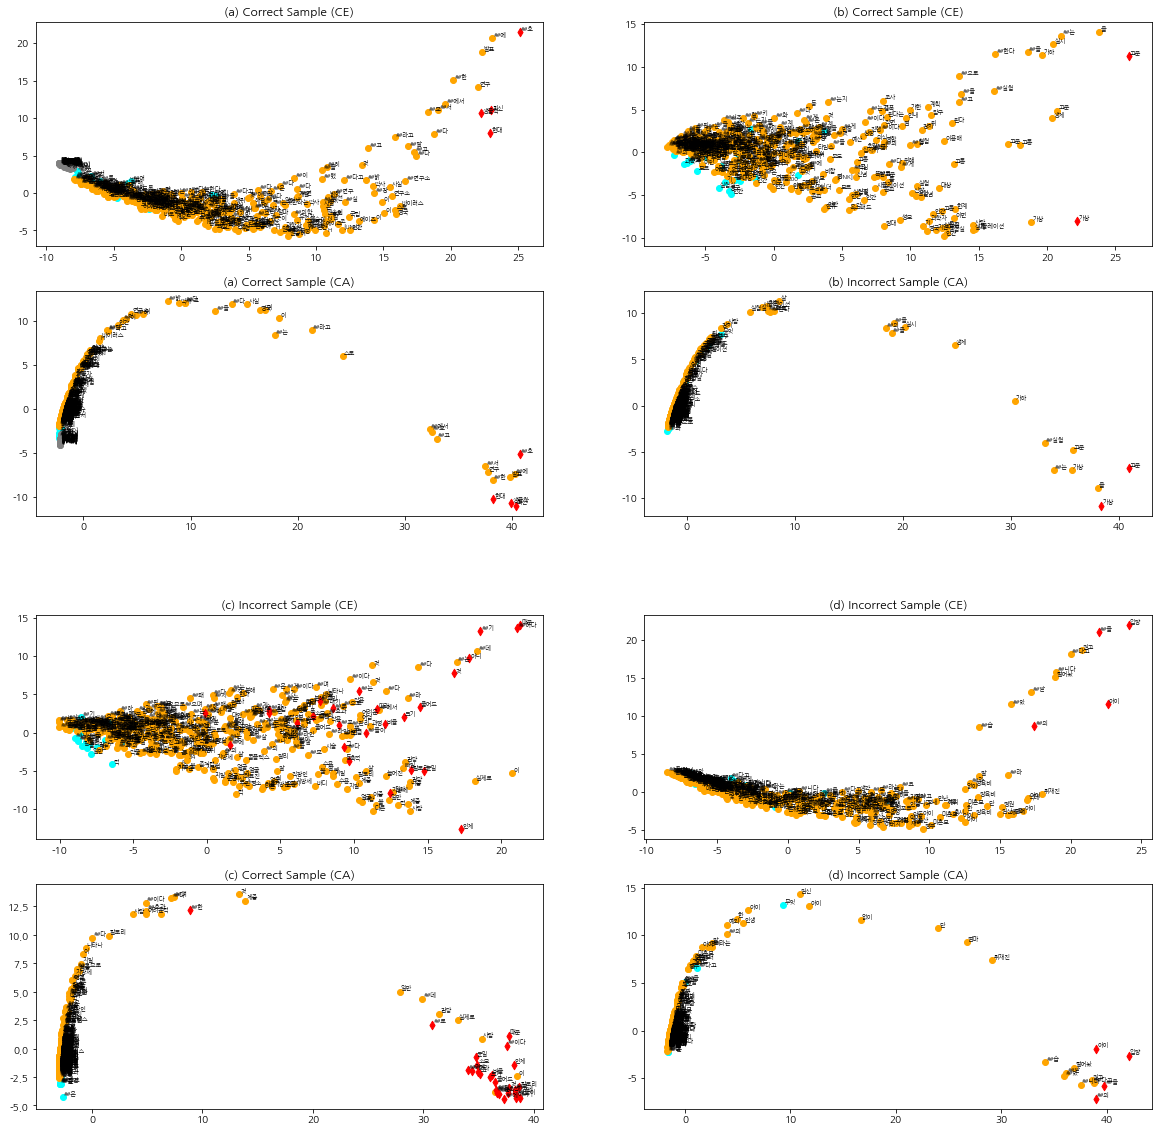

In [74]:
plt.rcParams['figure.figsize'] = [20, 20]

fig = plt.figure()
gs0 = fig.add_gridspec(2, 2)
gs00 = gs0[0].subgridspec(2, 1)
for i in range(2):
    ax = fig.add_subplot(gs00[i, 0])
    if i == 0:
        title = '(a) Correct Sample (CE)'
    else:
        title = '(a) Correct Sample (CA)'
    # ax.set_title(title)
    vizualize_output(ax, both_correct[i], title)
gs01 = gs0[1].subgridspec(2, 1)
for i in range(2):
    ax = fig.add_subplot(gs01[i, 0])
    if i == 0:
        title = '(b) Correct Sample (CE)'
    else:
        title = '(b) Incorrect Sample (CA)'
    # ax.set_title(title)
    vizualize_output(ax, only_ce[i], title)
gs10 = gs0[2].subgridspec(2, 1)
for i in range(2):
    ax = fig.add_subplot(gs10[i, 0])
    if i == 0:
        title = '(c) Incorrect Sample (CE)'
    else:
        title = '(c) Correct Sample (CA)'
    # ax.set_title(title)
    vizualize_output(ax, only_contra[i], title)
gs11 = gs0[3].subgridspec(2, 1)
for i in range(2):
    ax = fig.add_subplot(gs11[i, 0])
    if i == 0:
        title = '(d) Incorrect Sample (CE)'
    else:
        title = '(d) Incorrect Sample (CA)'
    # ax.set_title(title)
    vizualize_output(ax, both_incorrect[i], title)

fig.subplots_adjust(hspace=0.2)
# fig.suptitle('test')

In [75]:
with open(f'../result/viz_{source}.pkl', 'wb') as f:
    pickle.dump({'both_correct': both_correct,
                 'both_incorrect': both_incorrect,
                 'only_ce': only_ce,
                 'only_contra': only_contra}, f)


In [44]:
def visualize_bert_output(output_sample, title='vizualizing qa output'):
    coordinates = PCA(n_components=2).fit_transform(output_sample['bert_output'])
    text = output_sample['text']
    plt.clf()
    fig, ax = plt.subplots()
    
    for i, vector in enumerate(coordinates):
        if i >= len(text):
            break
        if text[i] in string.punctuation or text[i] == '[CLS]' or text[i] == '[SEP]':
            continue
        
        color = COLOR_LABEL_MAPPING['default']
        marker = MARKER_LABEL_MAPPING['default']
        if i in output_sample['question_ids']:
            color = COLOR_LABEL_MAPPING['question']
            marker = MARKER_LABEL_MAPPING['question']
        elif i in output_sample['context_ids']:
            color = COLOR_LABEL_MAPPING['context']
            marker = MARKER_LABEL_MAPPING['context']
        elif i in output_sample['answer_ids']:
            continue  # draw answers last for convenience

        ax.scatter(vector[0], vector[1], c=color, marker=marker)
        ax.text(vector[0]+0.1, vector[1]+0.2, text[i], fontsize=6)
    
    for i, vector in enumerate(coordinates):
        if i >= len(text):
            break
        if text[i] in string.punctuation or text[i] == '[CLS]' or text[i] == '[SEP]':
            continue

        color = COLOR_LABEL_MAPPING['answer']
        marker = MARKER_LABEL_MAPPING['answer']
        if i in output_sample['answer_ids']:
            ax.scatter(vector[0], vector[1], c=color, marker=marker)
            ax.text(vector[0]+0.1, vector[1]+0.2, text[i], fontsize=6)

    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_title(title)
    fig.add_axes(ax)
    fig.canvas.draw()
    fig_data = np.array(fig.canvas.renderer._renderer)
    plt.close()

    return fig_data

In [ ]:
visualize_bert_output(viz_correct[0])

# Get Contexts

In [ ]:
def addID(data):
    ids = []
    for context, question in tqdm(zip(data['context'], data['question']), total=len(data['context'])):
        context = context.replace('\u200b', '')
        id = question + context
        id = hashlib.shake_256(id.encode()).hexdigest(5)
        ids.append(id)
        data['id'] = ids
    return data

In [ ]:
def getContexts(data, features):
    ft_valid = []
    # data_with_ids = addID(data)
    ids = data['id']
    for f in tqdm(features, total=len(features)):
        f_id = f.id
        if f_id in ids:
            idx = ids.index(f_id)
            context = data['context'][idx]
            question = data['question'][idx]
            answers = data['answers'][idx]
            # source = data['source'][idx]
            ft_valid.append({'id': f_id,
                             'context': context,
                             'question': question,
                             'answers': answers})
    return ft_valid


In [ ]:
with open('../data/pkl/valid_book_data.json', 'w') as f:
    json.dump({'data':book_valid_contexts}, f)

In [38]:
def read_file(file_path, has_src=False):
    with open(file_path) as f:
        data = json.load(f)

    qa_data = defaultdict(list)
    for doc in data['data']:
        if has_src:
            source = doc['source']
        else:
            source = "all"
        for paragraph in doc['paragraphs']:
            context = paragraph['context'].replace('\u200b', '')
            for question_and_answers in paragraph['qas']:
                is_impossible = question_and_answers['is_impossible'] if 'is_impossible' in question_and_answers else None
                if not is_impossible:
                    question = question_and_answers['question']
                    answers = question_and_answers['answers']
                    id = question_and_answers['id']
                    for answer in answers:
                        # id = question + context
                        # id = hashlib.shake_256(id.encode()).hexdigest(5)
                        qa_data['id'].append(id)
                        qa_data['context'].append(context)
                        qa_data['question'].append(question)
                        qa_data['answers'].append(answer)
                        if has_src:
                            qa_data['source'].append(source)
    return qa_data


def convert_to_features(qa_data, tokenizer, max_len, has_src=False):
    encodings = []
    for idx, (id, context, question, answers) in tqdm(enumerate(zip(qa_data['id'],
                                                                    qa_data['context'],
                                                                    qa_data['question'],
                                                                    qa_data['answers'])), total=len(qa_data['context'])):
        encoding = tokenizer(
            question,
            context,
            truncation=True,
            max_length=max_len,
            return_offsets_mapping=True,
            padding="max_length"
        )
        encoding['id'] = id
        if has_src:
            encoding['source'] = qa_data['source'][idx]
        else:
            encoding['source'] = None
        offset_mapping = encoding.pop("offset_mapping")
        encoding['offset_mapping'] = offset_mapping

        input_ids = encoding['input_ids']
        sequence_ids = encoding.sequence_ids(0)

        start_char = answers['answer_start']
        end_char = start_char + len(answers['text'])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if offset_mapping[token_start_index][0] <= start_char and offset_mapping[token_end_index][1] >= end_char:
            while token_start_index < len(offset_mapping) and offset_mapping[token_start_index][0] <= start_char:
                token_start_index += 1
            encoding["start_positions"] = token_start_index - 1
            while offset_mapping[token_end_index][1] >= end_char:
                token_end_index -= 1
            encoding["end_positions"] = token_end_index + 1
            # if encoding['start_positions'] < encoding['end_positions']:
            #     encodings.append(encoding)
            encodings.append(encoding)

    return [InputFeature(enc['id'],
                         enc['input_ids'],
                         enc['token_type_ids'],
                         enc['attention_mask'],
                         enc['start_positions'],
                         enc['end_positions'],
                         enc['offset_mapping'],
                         enc['source']) for enc in encodings]

In [39]:
valid_hub_data = read_file(os.path.join(NEWSQA_PATH, NEWS_TEST), has_src=True)

In [34]:
len([src for src in valid_hub_data['source'] if src==source])

3599

In [43]:
valids = []
for id, context, question, answers, source in zip(valid_hub_data['id'],
                                                  valid_hub_data['context'],
                                                  valid_hub_data['question'],
                                                  valid_hub_data['answers'],
                                                  valid_hub_data['source']):
    valids.append({'id': id,
                   'context': context,
                   'question': question,
                   'answers': answers, 'source': source})


In [45]:
with open('../data/pkl/valid_hub_data.json', 'w') as f:
    json.dump({'data':valids}, f)

len(valid_hub_data['id'])

23169

In [42]:
valid_hub_data.keys()

dict_keys(['id', 'context', 'question', 'answers', 'source'])